In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader as tf_dataloader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from collections import OrderedDict

In [2]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

batch_size = 1

trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
trainloader = tf_dataloader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
testloader = tf_dataloader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))  # MNIST classes are digits from 0 to 9


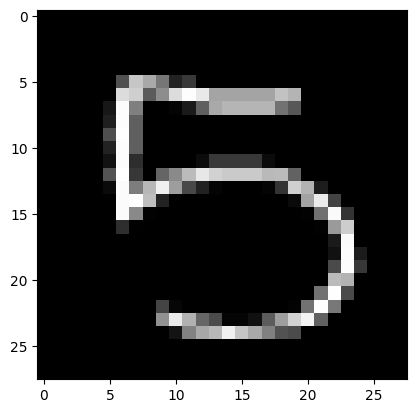

5    


In [4]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.MaxPool2d(kernel_size=3, stride=3, return_indices=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.MaxPool2d(kernel_size=3, stride=3, return_indices=True),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=256, out_features=128),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=128, out_features=10),
            nn.Softmax(dim=1)
        )
        
        self.conv_layers_indices = [0, 2]
        
        self.feature_maps = OrderedDict()
        
        self.pool_locs = OrderedDict()
        
    def forward(self, x):
        for idx, layer in enumerate(self.features):
            if isinstance(layer, nn.MaxPool2d):
                x, location = layer(x)
                self.pool_locs[idx] = location
            else:
                x = layer(x)
                
        output = self.classifier(x)
        return output
                    
net = Net()


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [7]:
epochs = 2
patience = 2  # Define the number of epochs to tolerate before early stopping
best_loss = float('inf')
counter = 0

y = []
images = []

for epoch in range(epochs):
    output_tensors = []
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        if epoch == epochs-1:
            images.append(inputs)
            y.append(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:  # print every 1000 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0
    
    # Calculate test loss
    test_loss = 0.0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    
    # Print test loss for the epoch
    print(f"Test Loss: {test_loss / len(testloader)}")
    
    # Check for early stopping
    if test_loss < best_loss:
        best_loss = test_loss
        counter = 0
        # Save the best model
        torch.save(net.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            images.append(inputs)
            y.append(labels)
            print(f"Early stopping at epoch {epoch + 1}")
            break
    
print("Finished Training")

[1,  1000] loss: 1.091
[1,  2000] loss: 0.934
[1,  3000] loss: 0.868
[1,  4000] loss: 0.840
[1,  5000] loss: 0.821
[1,  6000] loss: 0.796
[1,  7000] loss: 0.788
[1,  8000] loss: 0.789
[1,  9000] loss: 0.780
[1, 10000] loss: 0.772
[1, 11000] loss: 0.772
[1, 12000] loss: 0.779
[1, 13000] loss: 0.776
[1, 14000] loss: 0.765
[1, 15000] loss: 0.763
[1, 16000] loss: 0.771
[1, 17000] loss: 0.764
[1, 18000] loss: 0.766
[1, 19000] loss: 0.763
[1, 20000] loss: 0.761
[1, 21000] loss: 0.764
[1, 22000] loss: 0.762
[1, 23000] loss: 0.761
[1, 24000] loss: 0.761
[1, 25000] loss: 0.756
[1, 26000] loss: 0.763
[1, 27000] loss: 0.755
[1, 28000] loss: 0.759
[1, 29000] loss: 0.761
[1, 30000] loss: 0.762
[1, 31000] loss: 0.761
[1, 32000] loss: 0.758
[1, 33000] loss: 0.751
[1, 34000] loss: 0.761
[1, 35000] loss: 0.758
[1, 36000] loss: 0.756
[1, 37000] loss: 0.755
[1, 38000] loss: 0.757
[1, 39000] loss: 0.752
[1, 40000] loss: 0.757
[1, 41000] loss: 0.749
[1, 42000] loss: 0.751
[1, 43000] loss: 0.752
[1, 44000] 

In [8]:
# Evaluating the trained model on test data
net.load_state_dict(torch.load('best_model.pth'))
net.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f} %')

Test Accuracy: 97.86 %


In [9]:
torch.save(net.state_dict(), 'net_deconv.pth')